In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout

In [16]:
from sklearn.metrics import classification_report 
from sklearn.metrics import f1_score ,accuracy_score

In [17]:
import cv2, imutils
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
    [0, 180, 0, 256, 0, 256])
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist)
    return hist.flatten()

In [18]:
import os
import pandas as pd
cwd = os.getcwd()
print(cwd)
df = pd.read_csv(cwd + "\\..\\data_csv\\preprocessing_data.csv")
print(df)

d:\facial240\neural_network
                                 image  emotion
0      facial-expressions_2868588k.jpg        0
1      facial-expressions_2868585k.jpg        7
2      facial-expressions_2868584k.jpg        2
3      facial-expressions_2868582k.jpg        3
4               Aaron_Eckhart_0001.jpg        5
...                                ...      ...
33298      SURPRISE/surprise (987).png        7
33299      SURPRISE/surprise (988).jpg        7
33300       SURPRISE/surprise (99).jpg        7
33301      SURPRISE/surprise (993).jpg        7
33302      SURPRISE/surprise (996).jpg        7

[33303 rows x 2 columns]


In [19]:
raw_images =  []
labels = []
for i, row in df.iterrows():
    image_path = row['image']
    label = row['emotion']
    full_image_path = os.path.dirname(cwd) + "\\cleaned_images\\" + image_path
    image = cv2.imread(full_image_path)
    pixels = extract_color_histogram(image)

    raw_images.append(pixels)
    labels.append(label)
    if i > 0 and i % 1000 == 0: print('[INFO] processed {}/{}'.format(i, len(df)))

[INFO] processed 1000/33303
[INFO] processed 2000/33303
[INFO] processed 3000/33303
[INFO] processed 4000/33303
[INFO] processed 5000/33303
[INFO] processed 6000/33303
[INFO] processed 7000/33303
[INFO] processed 8000/33303
[INFO] processed 9000/33303
[INFO] processed 10000/33303
[INFO] processed 11000/33303
[INFO] processed 12000/33303
[INFO] processed 13000/33303
[INFO] processed 14000/33303
[INFO] processed 15000/33303
[INFO] processed 16000/33303
[INFO] processed 17000/33303
[INFO] processed 18000/33303
[INFO] processed 19000/33303
[INFO] processed 20000/33303
[INFO] processed 21000/33303
[INFO] processed 22000/33303
[INFO] processed 23000/33303
[INFO] processed 24000/33303
[INFO] processed 25000/33303
[INFO] processed 26000/33303
[INFO] processed 27000/33303
[INFO] processed 28000/33303
[INFO] processed 29000/33303
[INFO] processed 30000/33303
[INFO] processed 31000/33303
[INFO] processed 32000/33303
[INFO] processed 33000/33303


In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(np.array(raw_images), np.array(labels), test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [22]:
import tensorflow as tf

def classification_model_multi():
    model = Sequential()
    model.add(Dense(124, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(124, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def classification_model_bin():
    model = Sequential()
    model.add(Dense(124, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(124, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='softmax'))
    opt = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
from hyperopt.pyll.base import scope 
from hyperopt import hp
#quniform returns float, some parameters require int; use this to force int
space = {
         'rate'       : hp.uniform('rate',0.01,0.5),
         'dropout'    : hp.uniform('dropout',0.01,0.5),
         'units1'      : scope.int(hp.quniform('units1',10,100,5)),
         'units2'      : scope.int(hp.quniform('units2',10,100,5)),
         'units3'      : scope.int(hp.quniform('units3',10,100,5)),
         'units4'      : scope.int(hp.quniform('units4',10,100,5)),
         'batch_size' : scope.int(hp.quniform('batch_size',100,250,25)),
         'layers'     : scope.int(hp.quniform('layers',1,4,1)),
         'optimizer'  : hp.choice('optimizer', ['adam', 'adadelta', 'sgd', 'RMSprop']),
         'epochs'     : scope.int(hp.quniform('epochs', 100, 200, 1)),
         'activation' : hp.choice('activation', ['relu', 'sigmoid', 'tanh', 'elu']),
        }

In [24]:
def f_nn(params):
    print("params", params)

    # Keras LSTM model
    model = Sequential()
    
    if params['layers'] == 1:
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        #model.add(Dropout(rate=params['rate']))
    else:
        # First layer specifies input_shape and returns sequences
        model.add(Dense(params['units1'], activation=params['activation'], input_shape=(X_train.shape[1],)))
        #model.add(Dropout(rate=params['rate']))
        
        # Middle layers return sequences
        for i in range(params['layers']-2):
            model.add(Dense(params['units' + str(i + 2)], activation=params['activation']))
            #model.add(Dropout(rate=params['rate']))
        
        # Last layer doesn't return anything
        model.add(Dense(8, activation='softmax'))
        model.add(Dropout(rate=params['rate']))

    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=params['optimizer'], loss='mean_squared_error')
    
    es = EarlyStopping(monitor='val_loss',mode='min', verbose=1,patience=15)
    '''result = model.fit(X_train, y_train, 
                       verbose=0, 
                       validation_split=0.1,
                       batch_size=params['batch_size'],
                       epochs=200)'''
    result =  model.fit(X_train, y_train, validation_data=(X_val, y_val,), batch_size=params['batch_size'], epochs=params["epochs"], verbose=0)
    
    # Get the lowest validation loss of the training epochs
    validation_loss = np.amin(result.history['val_loss']) 
    print('Best validation loss of epoch:', validation_loss)
    
    return {'loss': validation_loss, 
            'status': STATUS_OK, 
            'model': model, 
            'params': params}

In [25]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from keras.callbacks import EarlyStopping
trials = Trials()
best = fmin(f_nn, 
            space, 
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

params                                                
{'activation': 'elu', 'batch_size': 200, 'dropout': 0.4748543803627131, 'epochs': 193, 'layers': 3, 'optimizer': 'sgd', 'rate': 0.10123082725341612, 'units1': 75, 'units2': 25, 'units3': 90, 'units4': 90}
Best validation loss of epoch:                        
0.1016133725643158                                    
params                                                                          
{'activation': 'elu', 'batch_size': 125, 'dropout': 0.32256808073721593, 'epochs': 101, 'layers': 2, 'optimizer': 'adam', 'rate': 0.35289170240918954, 'units1': 70, 'units2': 15, 'units3': 65, 'units4': 65}
Best validation loss of epoch:                                                  
0.09916370362043381                                                             
params                                                                           
{'activation': 'elu', 'batch_size': 200, 'dropout': 0.11098471306155115, 'epochs': 114, 'layers': 

In [26]:
print(best)

{'activation': 0, 'batch_size': 125.0, 'dropout': 0.31986211634290024, 'epochs': 192.0, 'layers': 1.0, 'optimizer': 0, 'rate': 0.40286171410282134, 'units1': 75.0, 'units2': 95.0, 'units3': 85.0, 'units4': 30.0}


In [27]:
best_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']
best_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
worst_model = trials.results[np.argmax([r['loss'] for r in trials.results])]['model']
worst_params = trials.results[np.argmax([r['loss'] for r in trials.results])]['params']

In [28]:
print(best_model)
print(best_params)

{'activation': 'relu', 'batch_size': 125, 'dropout': 0.31986211634290024, 'epochs': 192, 'layers': 1, 'optimizer': 'adam', 'rate': 0.40286171410282134, 'units1': 75, 'units2': 95, 'units3': 85, 'units4': 30}


In [ ]:
'''# Best window
best_window = best_params['window']
# Format data
X_train, y_train, X_test, y_test = format_data(window=best_window)
Yp = best_model.predict(X_test)'''

In [ ]:
'''def forecast(X_test,y_test,model,window):
    Yf = y_test.copy()
    for i in range(len(Yf)):
        if i < window:
            pass
        else:
            Xu = X_test[i,:,0]
            Xy = Yf[i-window:i]
            Xf = np.vstack((Xu,Xy)).T
            Xf = np.reshape(Xf, (1, Xf.shape[0], Xf.shape[1])) 
            Yf[i] = model.predict(Xf)[0] 
            
    return Yf'''

ANGER
<class 'numpy.ndarray'> [[0.06371864 0.44149336 0.24265932 ... 0.         0.         0.        ]
 [0.07937567 0.36383924 0.28272468 ... 0.         0.         0.        ]
 [0.07744719 0.4058253  0.24549863 ... 0.         0.         0.        ]
 ...
 [0.03373284 0.10399405 0.19480246 ... 0.         0.         0.        ]
 [0.3770914  0.35567155 0.28794402 ... 0.         0.         0.        ]
 [0.16595338 0.23644875 0.40159863 ... 0.         0.         0.        ]]
Epoch 1/100


C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


ValueError: in user code:

    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\losses.py", line 1932, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\user\AppData\Roaming\Python\Python38\site-packages\keras\backend.py", line 5247, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 8) vs (None, 2)).


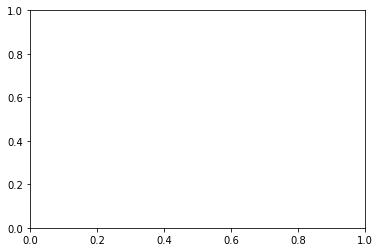

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

dictionary = ['ANGER', 'CONTEMPT', 'DISGUST', 'FEAR', 'HAPPINESS',  'NEUTRAL', 'SADNESS', 'SURPRISE']

for emo in range(8):
    print(dictionary[emo])

    emo_feature = []
    emo_target = []

    for i in range(len(df['emotion'])):
        if df['emotion'][i] == emo:
            emo_target.append(1)
        else:
            emo_target.append(0)
        
        imagePath = cwd + "/../cleaned_images/" + df['image'][i]
        image = cv2.imread(imagePath)
        pixels = extract_color_histogram(image)
        emo_feature.append(pixels)

    emo_feature = np.array(emo_feature)
    emo_target = np.array(emo_target)

    # import data
    X = X_train = emo_feature
    y = y_train = emo_target
    print(type(X_train), X_train)

    history = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()

    # create model
    model = classification_model_bin()

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    for i, (train, val) in enumerate(cv.split(X_train, y_train)):
        X_train, X_val = X[train], X[val]
        y_train, y_val = y[train], y[val]

        le = preprocessing.LabelEncoder()
        le.fit(y_train)
        y_train = le.transform(y_train)
        y_val = le.transform(y_val)
        y_train = to_categorical(y_train)
        y_val = to_categorical(y_val)

        # fit model
        model.fit(X_train, y_train, validation_data=(X_val, y_val,), epochs=100, verbose=2)

        # predict
        y_pred = model.predict(X_val)
        clf_probs = model.predict_proba(X_val)

        # store model report in history list
        history.append(classification_report(y_val, y_pred))

        # get loss and accuracy
        acc = accuracy_score(y_val, y_pred)
        loss = log_loss(y_val, clf_probs)
        print(f'====================Fold {i}====================', '\n')
        print(f"accuracy_score : {acc}")
        print(f"log_loss : {loss}\n")

        # plot ROC curve
        viz = RocCurveDisplay.from_predictions(y_val, y_pred)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        
    # middle line
    ax.plot([0, 1], [0, 1], 'k--')

    # mean line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    # std
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title="Receiver operating characteristic")
    ax.legend(loc="lower right")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig('graph/' + dictionary[emo] + '/ann.jpg')
    plt.show()

In [ ]:
model = classification_model_multi()
model.fit(X_train, y_train, validation_data=(X_val, y_val,), epochs=100, verbose=2)

In [ ]:
value = model.predict(X_test)
y_pred =np.argmax(value,axis=1)
y_true = np.argmax(y_test,axis=1)

In [ ]:
print(classification_report(y_true,y_pred))

In [ ]:
value = model.predict(X_test)
y_pred = np.argmax(value,axis=1)
y_true = np.argmax(y_test,axis=1)

In [ ]:
y_pred_arr = list(y_pred)
print("len : ", len(y_pred_arr))
score = 0
for i in range(len(y_pred_arr)):
    if(list(y_pred)[i] == list(y_true)[i]): score += 1
max_score = len(list(y_pred))
print(f"Final Score : {score}/{max_score}")
print("Accuracy : ", 100 * score / max_score)


In [ ]:
# Hyperparameter Process #

In [ ]:
from scipy.integrate import odeint
# Parameters and time for FOPDT model
ns = 10000
t = np.linspace(0,ns-1,ns)
u = np.zeros(ns)
# Additional FOPDT parameters
yp0 = 0.0
u0 = u[0]
Km = 0.67
taum = 160.0
def fopdt(y,t,um,Km,taum):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    # calculate derivative
    dydt = (-(y-yp0) + Km * (um-u0))/taum
    return dydt

def sim_model(Km,taum):
    # array for model values
    ym = np.zeros(ns)
    # initial condition
    ym[0] = yp0
    # loop through time steps    
    for i in range(0,ns-1):
        ts = [t[i],t[i+1]]
        y1 = odeint(fopdt,ym[i],ts,args=(u[i],Km,taum))
        ym[i+1] = y1[-1]
    return ym

In [ ]:
import random
end = 60 # leave 1st minute of u as 0
while end <= ns:
    start = end
    end += random.randint(300,900) # keep new Q1s value for anywhere from 5 to 15 minutes
    u[start:end] = random.randint(0,100)

In [ ]:
# Simulate FOPDT model
y = sim_model(Km,taum)

In [ ]:
# Add Gaussian noise
noise = np.random.normal(0,0.2,ns)
y += noise

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Scale data
data = np.vstack((u,y)).T
s = MinMaxScaler(feature_range=(0,1))
data_s = s.fit_transform(data)